# **Machine Learning: Future of Pricing in Real Estate**

## **Load & Inspect Data**

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("kc_house_data.csv")
print("Raw dataset shape:", df.shape)
print(df.head(3))

print("\nData types (raw):")
print(df.dtypes)

Raw dataset shape: (21613, 21)
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7      1180.0              0   
1      7242     2.0           0     0  ...      7      2170.0            400   
2     10000     1.0           0     0  ...      6       770.0              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   

   sqft_lot15  
0        5650  
1        7639  
2 

**Findings:**

- Float Variables: price, sqft_above, lat, long

- Integer Variables: id, sqft_living, sqft_lot, sqdt_basement, sqft_living15, sqft_lot15

- Questionable Variables:

  - date & yr_built: Should be datetime

  - id: Cannot be used as predictor
 
  - yr_renovated: Contains 0 values which means the house was not renovated
 
  - bathrooms & floors (float) - Should be categorical variable
 
  - bedrooms, grade, condition, zipcode, waterfront & view (integer) - These should be categorical variables.

### **Numeric Data Check**

In [2]:
num_df = df.select_dtypes(include=['float64', 'int64']).copy()
remove_cols = [
    'id', 'zipcode', 'yr_built', 'yr_renovated', 'bedrooms', 'grade',
    'condition', 'bathrooms', 'floors', 'view', 'waterfront'
]
num_df.drop(columns=[c for c in remove_cols if c in num_df.columns],
            inplace=True, errors='ignore')

summary_stats = pd.DataFrame({
    'mean': num_df.mean(),
    'sd': num_df.std(),
    'min': num_df.min(),
    'max': num_df.max(),
    'median': num_df.median(),
    'n': len(num_df),
    'missing': num_df.isnull().sum()
})
summary_stats['cv'] = summary_stats['sd'] / summary_stats['mean']
print("\nNumeric Summary Statistics:")
print(summary_stats.round(3))


Numeric Summary Statistics:
                     mean          sd        min          max      median  \
price          540088.142  367127.196  75000.000  7700000.000  450000.000   
sqft_living      2079.900     918.441    290.000    13540.000    1910.000   
sqft_lot        15106.968   41420.512    520.000  1651359.000    7618.000   
sqft_above       1788.396     828.128    290.000     9410.000    1560.000   
sqft_basement     291.509     442.575      0.000     4820.000       0.000   
lat                47.560       0.139     47.156       47.778      47.572   
long             -122.214       0.141   -122.519     -121.315    -122.230   
sqft_living15    1986.552     685.391    399.000     6210.000    1840.000   
sqft_lot15      12768.456   27304.180    651.000   871200.000    7620.000   

                   n  missing     cv  
price          21613        0  0.680  
sqft_living    21613        0  0.442  
sqft_lot       21613        0  2.742  
sqft_above     21613        2  0.463  
sqft_

#### **Numeric: Visualize High-CV Variables**

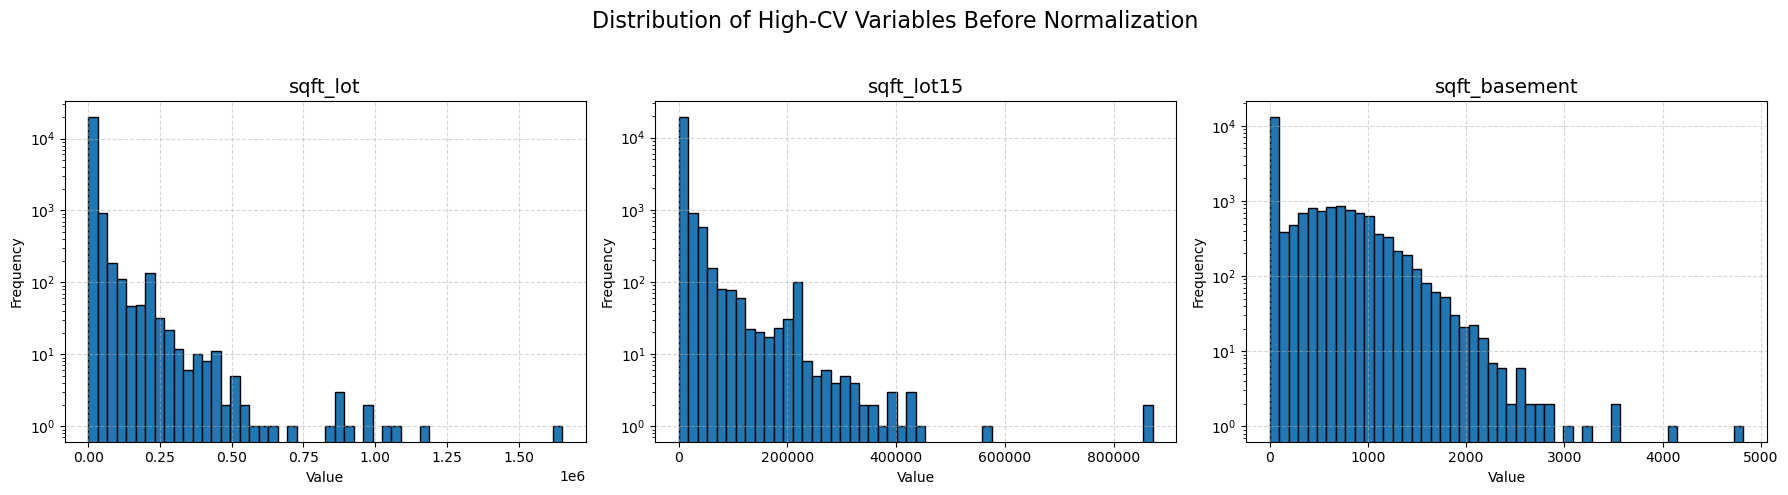


Findings: High CV variables: sqft_lot, sqft_lot15, sqft_basement (skewed).
Missing values example: sqft_above may have missing entries (will drop rows later).


In [3]:
import matplotlib.pyplot as plt

cols_to_check = ['sqft_lot', 'sqft_lot15', 'sqft_basement']
fig, axes = plt.subplots(1, len(cols_to_check), figsize=(18, 5))

for ax, col in zip(axes, cols_to_check):
    if col in df.columns:
        ax.hist(df[col].dropna(), bins=50, edgecolor='black')
        ax.set_title(col, fontsize=14)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        ax.grid(which='major', linestyle='--', alpha=0.5)

plt.suptitle('Distribution of High-CV Variables Before Normalization', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\nFindings: High CV variables: sqft_lot, sqft_lot15, sqft_basement (skewed).")
print("Missing values example: sqft_above may have missing entries (will drop rows later).")

**Findings:**

- High CV Variables:sqft_lot, sqft_lot15, sqft_basement

  - All have positive skew with long tail (extreme outliers)

- Missing Values: sqft_above

**Next Steps:**

- Normalize with Min-Max Scaler: sqft_lot, sqft_lot15, sqft_basement

- Drop rows with missing values

### **Categorical Data Check**

In [4]:
cat_cols = [
    'zipcode', 'yr_built', 'yr_renovated', 'bedrooms', 'grade',
    'condition', 'bathrooms', 'floors', 'view', 'waterfront'
]
cat_df = df[[c for c in cat_cols if c in df.columns]].copy()

summary_stats_2 = pd.DataFrame({
    'min': cat_df.min(),
    'max': cat_df.max(),
    'n': len(cat_df),
    'missing': cat_df.isnull().sum(),
    'unique_vals': cat_df.nunique()
})
print("\nCategorical Summary Statistics:")
print(summary_stats_2)

high_cardinality = summary_stats_2[summary_stats_2['unique_vals'] > 10] if not summary_stats_2.empty else pd.DataFrame()
print("\nVariables with >10 unique categories:")
print(high_cardinality)


Categorical Summary Statistics:
                  min      max      n  missing  unique_vals
zipcode       98001.0  98199.0  21613        0           70
yr_built       1900.0   2015.0  21613        0          116
yr_renovated      0.0   2015.0  21613        0           70
bedrooms          0.0     33.0  21613        0           13
grade             1.0     13.0  21613        0           12
condition         1.0      5.0  21613        0            5
bathrooms         0.0      8.0  21613        0           30
floors            1.0      3.5  21613        0            6
view              0.0      4.0  21613        0            5
waterfront        0.0      1.0  21613        0            2

Variables with >10 unique categories:
                  min      max      n  missing  unique_vals
zipcode       98001.0  98199.0  21613        0           70
yr_built       1900.0   2015.0  21613        0          116
yr_renovated      0.0   2015.0  21613        0           70
bedrooms          0.0     33

#### **Categorical: Distribution Check(floors & view)**

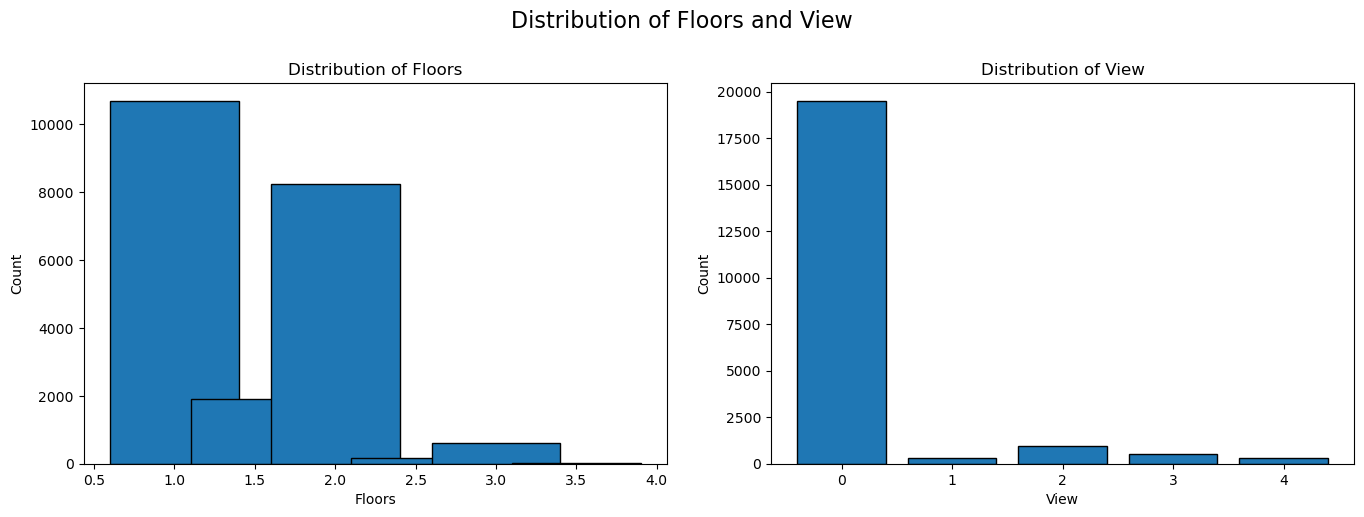

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
if 'floors' in df.columns:
    floor_counts = df['floors'].value_counts().sort_index()
    axes[0].bar(floor_counts.index, floor_counts.values, edgecolor='black')
    axes[0].set_title('Distribution of Floors')
    axes[0].set_xlabel('Floors')
    axes[0].set_ylabel('Count')
if 'view' in df.columns:
    view_counts = df['view'].value_counts().sort_index()
    axes[1].bar(view_counts.index, view_counts.values, edgecolor='black')
    axes[1].set_title('Distribution of View')
    axes[1].set_xlabel('View')
    axes[1].set_ylabel('Count')
plt.tight_layout(pad=2.0)
plt.suptitle('Distribution of Floors and View', fontsize=16, y=1.05)
plt.show()

**Findings:**

- Many (>10) Unique Values: id, zipcode, yr_built, yr_renovated, bedrooms, grade, bathrooms

- Distribution of floors and view is uneven. Not recommended to merge.

**Next Steps:**

- Drop variables: id

- Convert to categorical / dummy variables: condition, view

- Bucket & dummy: bathrooms, zipcode, bedrooms, grade

- Convert to datetime: date

    - Retain yr_built data type

- Convert to boolean (0 = no, 1 = yes): yr_renovated

## **Data Preparation**

### **Numeric Variables**

#### **Numeric: Normalization**

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Clip extreme outliers and scale selected columns (Min-Max)
cols_to_scale = [c for c in ['sqft_lot', 'sqft_lot15', 'sqft_basement'] if c in df.columns]

for col in cols_to_scale:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower, upper)

if cols_to_scale:
    scaler = MinMaxScaler()
    for col in cols_to_scale:
        df[[col]] = scaler.fit_transform(df[[col]])
        print(f"{col}: processed with Min-Max scaling (0–1 range)")

sqft_lot: processed with Min-Max scaling (0–1 range)
sqft_lot15: processed with Min-Max scaling (0–1 range)
sqft_basement: processed with Min-Max scaling (0–1 range)


#### **Numeric: Correlation**

In [7]:
import seaborn as sns

exclude_patterns = (
    '_bin', '_cat', '_dummy', 'condition_', 'view_', 'grade_', 'zipcode_',
    'bathrooms_', 'bedrooms_', 'floors_', 'renovated_'
)
exclude_explicit = {
    'id', 'floors', 'view', 'condition', 'zipcode', 'yr_built',
    'yr_renovated', 'renovated', 'grade', 'waterfront', 'bedrooms', 'bathrooms'
}

num_df_new = df.select_dtypes(include=['float64', 'int64', 'bool']).drop(
    columns=[c for c in df.columns if any(p in c for p in exclude_patterns) or c in exclude_explicit],
    errors='ignore'
).copy()

summary_stats_new = num_df_new.describe().T.rename(columns={'std': 'sd', '50%': 'median'})
summary_stats_new['missing'] = num_df_new.isnull().sum()
summary_stats_new['cv'] = (
    summary_stats_new['sd'] / summary_stats_new['mean']
).replace([np.inf, -np.inf], np.nan)
print("\nSummary Statistics of Final Numeric Data")
print(summary_stats_new[['mean', 'sd', 'min', 'max', 'median', 'missing', 'cv']].round(3))


Summary Statistics of Final Numeric Data
                     mean          sd        min          max      median  \
price          540088.142  367127.196  75000.000  7700000.000  450000.000   
sqft_living      2079.900     918.441    290.000    13540.000    1910.000   
sqft_lot            0.061       0.131      0.000        1.000       0.031   
sqft_above       1788.396     828.128    290.000     9410.000    1560.000   
sqft_basement       0.174       0.258      0.000        1.000       0.000   
lat                47.560       0.139     47.156       47.778      47.572   
long             -122.214       0.141   -122.519     -121.315    -122.230   
sqft_living15    1986.552     685.391    399.000     6210.000    1840.000   
sqft_lot15          0.069       0.127      0.000        1.000       0.041   

               missing     cv  
price                0  0.680  
sqft_living          0  0.442  
sqft_lot             0  2.136  
sqft_above           2  0.463  
sqft_basement        0  1.4

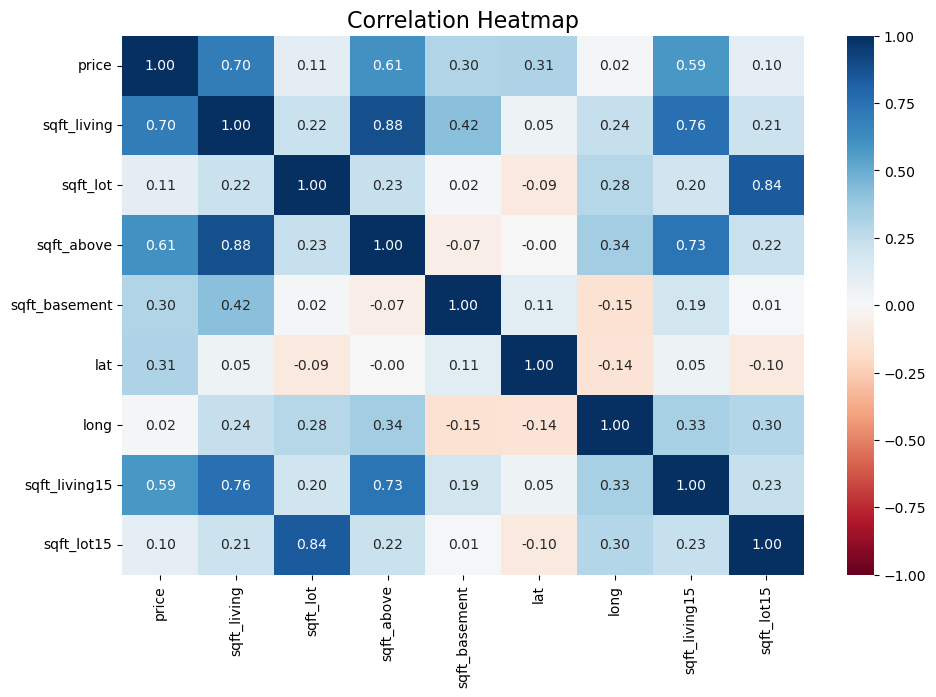

In [8]:
corr = num_df_new.corr()
plt.figure(figsize=(11, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [9]:
# High correlation pairs
features = num_df_new.drop(columns=['price'], errors='ignore')
corr_matrix = features.corr()
high_corr = (
    corr_matrix.where(lambda x: x >= 0.6)
               .stack()
               .reset_index()
               .rename(columns={'level_0': 'Variable1', 'level_1': 'Variable2', 0: 'Correlation'})
)
high_corr = high_corr[high_corr['Variable1'] != high_corr['Variable2']]
high_corr['OrderedPair'] = high_corr.apply(lambda x: tuple(sorted([x['Variable1'], x['Variable2']])), axis=1)
high_corr = high_corr.drop_duplicates(subset='OrderedPair').drop(columns='OrderedPair')
high_corr = high_corr.sort_values(by='Correlation', ascending=False).reset_index(drop=True)
print("\nHigh correlation pairs (>=0.6):")
print(high_corr)


High correlation pairs (>=0.6):
     Variable1      Variable2  Correlation
0  sqft_living     sqft_above     0.876644
1     sqft_lot     sqft_lot15     0.839234
2  sqft_living  sqft_living15     0.756420
3   sqft_above  sqft_living15     0.731871


**Next Steps:**

- Using PCA, merge high correlation pairs as follows:
  
  - lot_vars: sqft_lot, sqft_lot15
    
  - living_vars: sqft_living, sqft_above, sqft_living15

#### **Numeric: Drop Missing Values**

In [10]:
if 'sqft_above' in df.columns:
    before_shape = df.shape
    df = df.dropna(subset=['sqft_above'])
    print("Dataset shape after dropping missing sqft_above:", df.shape, " (was", before_shape, ")")

Dataset shape after dropping missing sqft_above: (21611, 21)  (was (21613, 21) )


#### **Numeric: PCA**

In [11]:
from sklearn.decomposition import PCA

lot_vars = [v for v in ['sqft_lot', 'sqft_lot15'] if v in df.columns]
living_vars = [v for v in ['sqft_living', 'sqft_above', 'sqft_living15'] if v in df.columns]

if lot_vars:
    scaler_lot = StandardScaler()
    lot_pc = PCA(n_components=1).fit_transform(scaler_lot.fit_transform(df[lot_vars]))
    df['lot_pc'] = lot_pc
if living_vars:
    scaler_living = StandardScaler()
    living_pc = PCA(n_components=1).fit_transform(scaler_living.fit_transform(df[living_vars]))
    df['living_pc'] = living_pc

print("\nFirst 5 rows with PCs (if created):")
print(df[['lot_pc', 'living_pc']].head() if 'lot_pc' in df.columns and 'living_pc' in df.columns else df.head())


First 5 rows with PCs (if created):
     lot_pc  living_pc
0 -0.438872  -1.532660
1 -0.327466   0.345237
2 -0.242021  -0.969437
3 -0.478590  -1.106383
4 -0.310916  -0.484994


### **Categorical Variables**

#### **Categorical: Drop Non-Predictors**

In [12]:
# Drop id column
df.drop(columns=['id'], inplace=True, errors='ignore')

#### **Categorical: Bucketing High-Cardinality Variables**

In [13]:
binning_specs = {
    'bedrooms': {'bins':[0,2,5,9,np.inf], 'labels':['0–2','3–5','6–9','10+']},
    'bathrooms': {'bins':[0,2,5,8], 'labels':['0–2','3–5','6–8']},
    'grade': {'bins':[0,3,6,9,13], 'labels':['1–3','4–6','7–9','10–13']},
    'zipcode': {'bins':10, 'method':'qcut'}
}

for var, spec in binning_specs.items():
    if var in df.columns:
        if spec.get('method') == 'qcut':
            df[f'{var}_bin'] = pd.qcut(df[var], q=spec['bins'], labels=False, duplicates='drop')
        else:
            df[f'{var}_bin'] = pd.cut(df[var], bins=spec['bins'], labels=spec['labels'], include_lowest=True)
        print(f"{var} binned > {var}_bin")

bedrooms binned > bedrooms_bin
bathrooms binned > bathrooms_bin
grade binned > grade_bin
zipcode binned > zipcode_bin


#### **Categorical: Creation of Dummy Variables**

In [14]:
cat_vars = [c for c in ['condition','floors','view','bedrooms_bin','bathrooms_bin','grade_bin','zipcode_bin'] if c in df.columns]
if cat_vars:
    df[cat_vars] = df[cat_vars].astype(str)
    df = pd.get_dummies(df, columns=cat_vars, drop_first=True, dtype=int)
    print("\nDummy variables created for:", cat_vars)


Dummy variables created for: ['condition', 'floors', 'view', 'bedrooms_bin', 'bathrooms_bin', 'grade_bin', 'zipcode_bin']


#### **Categorical: Type Conversion**

In [15]:
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
if 'yr_renovated' in df.columns:
    df['renovated'] = (df['yr_renovated'] > 0).astype(int)

## **Variable Selection**

In [16]:
# List of columns to exclude
exclude_cols = [
    'sqft_living', 'sqft_above', 'sqft_living15',
    'sqft_lot', 'sqft_lot15', 'bedrooms', 'bathrooms', 'grade',
    'view', 'zipcode', 'condition', 'floors'
]

# Candidate predictors: numeric/bool columns after preprocessing but excluding excluded list and 'price'
potential_predictors = [
    c for c in df.columns
    if c != 'price' and c not in exclude_cols
    and df[c].dtype in [np.int64, np.float64, np.int32, np.float32, np.bool_]
]
print("\nPotential numeric/bool predictors (sample):", potential_predictors[:30])

# For reproducibility and compatibility, fill NAs in predictors with 0 (or consider more advanced imputation)
df[potential_predictors] = df[potential_predictors].fillna(0)

# Create X and y for model building (we will create train/valid/test splits below)
X_full = df[potential_predictors].copy()
y_full = df['price'].copy()


Potential numeric/bool predictors (sample): ['waterfront', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'lot_pc', 'living_pc', 'condition_2', 'condition_3', 'condition_4', 'condition_5', 'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'view_1', 'view_2', 'view_3', 'view_4', 'bedrooms_bin_10+', 'bedrooms_bin_3–5', 'bedrooms_bin_6–9', 'bathrooms_bin_3–5', 'bathrooms_bin_6–8', 'grade_bin_1–3', 'grade_bin_4–6', 'grade_bin_7–9', 'zipcode_bin_1']


### **Train / Validation / Test Split**

In [17]:
from sklearn.model_selection import train_test_split

# We'll split into train (60%), valid (20%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2
print("\nShapes > Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

# For classification tasks (KNN), create binary target (expensive if > median)
median_price = y_full.median()
y_train_class = (y_train > median_price).astype(int)
y_valid_class = (y_valid > median_price).astype(int)
y_test_class = (y_test > median_price).astype(int)


Shapes > Train: (12966, 39) Valid: (4322, 39) Test: (4323, 39)


### **Variable Selection Process**

#### **1. Forward Selection**

In [18]:
import statsmodels.api as sm

def forward_selection_adjR2(trainX, trainy, candidates):
    selected = []
    best_adjR2 = -np.inf
    while True:
        improved = False
        best_feature = None
        for f in [c for c in candidates if c not in selected]:
            try:
                cols = selected + [f]
                model = sm.OLS(trainy, sm.add_constant(trainX[cols])).fit()
                if model.rsquared_adj > best_adjR2 + 1e-6:
                    best_adjR2 = model.rsquared_adj
                    best_feature = f
                    improved = True
            except Exception:
                continue
        if improved and best_feature is not None:
            selected.append(best_feature)
        else:
            break
    return selected

#### **2. Backward Elimination**

In [19]:
def backward_elimination_adjR2(trainX, trainy, candidates):
    selected = candidates.copy()
    best_adjR2 = sm.OLS(trainy, sm.add_constant(trainX[selected])).fit().rsquared_adj
    while True:
        adjR2_with_removal = {}
        for f in selected:
            trial = [c for c in selected if c != f]
            try:
                model = sm.OLS(trainy, sm.add_constant(trainX[trial])).fit()
                adjR2_with_removal[f] = model.rsquared_adj
            except Exception:
                adjR2_with_removal[f] = -np.inf
        # find feature whose removal gives the best adjR2
        to_remove, best_new_adjR2 = max(adjR2_with_removal.items(), key=lambda x: x[1])
        if best_new_adjR2 >= best_adjR2 - 1e-6 and len(selected) > 1:
            # if removing improves or does not decrease adjR2 (tie), remove it
            selected.remove(to_remove)
            best_adjR2 = best_new_adjR2
        else:
            break
    return selected

#### **3. Random Forest**

In [20]:
from sklearn.ensemble import RandomForestRegressor

def topk_random_forest(trainX, trainy, k=6, random_state=1):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1)
    rf.fit(trainX, trainy)
    importances = pd.Series(rf.feature_importances_, index=trainX.columns).sort_values(ascending=False)
    return importances.index.tolist()[:k], importances

# 4) RFE with LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def topk_rfe(trainX, trainy, k=6):
    lr = LinearRegression()
    selector = RFE(lr, n_features_to_select=k, step=1)
    selector = selector.fit(trainX, trainy)
    selected = list(trainX.columns[selector.support_])
    # return selected in order of ranking (optional)
    return selected

#### **4. LASSO (LassoCV) - select non-zero coefficients; if >k choose top k by abs(coef)**

In [21]:
from sklearn.linear_model import LassoCV

def topk_lasso(trainX, trainy, k=6, random_state=1):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(trainX)
    lasso = LassoCV(cv=5, random_state=random_state, n_alphas=100, max_iter=5000).fit(Xs, trainy)
    coefs = pd.Series(lasso.coef_, index=trainX.columns)
    nonzero = coefs[coefs != 0].abs().sort_values(ascending=False)
    if len(nonzero) == 0:
        # fallback: take top k by absolute coefficient from original (smallest alphas) or by correlation
        corr = trainX.corrwith(trainy).abs().sort_values(ascending=False)
        return corr.index.tolist()[:k], coefs
    else:
        chosen = nonzero.index.tolist()[:k]
        return chosen, coefs

#### **5. RFE with LinearRegression**

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def topk_rfe(trainX, trainy, k=6):
    lr = LinearRegression()
    selector = RFE(lr, n_features_to_select=k, step=1)
    selector = selector.fit(trainX, trainy)
    selected = list(trainX.columns[selector.support_])
    # return selected in order of ranking (optional)
    return selected

### **Run Variable Selection Methods**

#### **1. Forward Selection**

In [23]:
candidates = X_train.columns.tolist()

# Forward selection (get ordered list; then limit to 6)
fs_ordered = forward_selection_adjR2(X_train, y_train, candidates)
fs_top6 = fs_ordered[:6] if len(fs_ordered) >= 6 else fs_ordered
print("\nForward selection ordered (top shown):", fs_ordered[:20])
print("Forward selection top 6:", fs_top6)


Forward selection ordered (top shown): ['living_pc', 'lat', 'waterfront', 'yr_built', 'bathrooms_bin_6–8', 'long', 'zipcode_bin_6', 'sqft_basement', 'grade_bin_7–9', 'grade_bin_4–6', 'zipcode_bin_3', 'view_4', 'yr_renovated', 'view_3', 'condition_3', 'zipcode_bin_7', 'floors_2.5', 'view_2', 'view_1', 'renovated']
Forward selection top 6: ['living_pc', 'lat', 'waterfront', 'yr_built', 'bathrooms_bin_6–8', 'long']


#### **2. Backward Elimination**

In [24]:
be_selected = backward_elimination_adjR2(X_train, y_train, candidates.copy())
be_top6 = be_selected[:6] if len(be_selected) >= 6 else be_selected
print("\nBackward elimination selected (full):", be_selected)
print("Backward elimination top 6:", be_top6)


Backward elimination selected (full): ['waterfront', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'living_pc', 'condition_2', 'condition_3', 'condition_4', 'condition_5', 'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'view_1', 'view_2', 'view_3', 'view_4', 'bedrooms_bin_10+', 'bedrooms_bin_3–5', 'bedrooms_bin_6–9', 'bathrooms_bin_6–8', 'grade_bin_4–6', 'grade_bin_7–9', 'zipcode_bin_1', 'zipcode_bin_2', 'zipcode_bin_3', 'zipcode_bin_4', 'zipcode_bin_5', 'zipcode_bin_7', 'zipcode_bin_8', 'zipcode_bin_9', 'renovated']
Backward elimination top 6: ['waterfront', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long']


#### **3. Random Forest**

In [25]:
rf_top6, rf_importances = topk_random_forest(X_train, y_train, k=6, random_state=1)
print("\nRandom Forest top 6:", rf_top6)
print("Top random forest importances (top 10):")
print(rf_importances.head(10))


Random Forest top 6: ['living_pc', 'lat', 'long', 'waterfront', 'lot_pc', 'yr_built']
Top random forest importances (top 10):
living_pc        0.541531
lat              0.200417
long             0.112877
waterfront       0.029857
lot_pc           0.024850
yr_built         0.021506
grade_bin_7–9    0.019331
sqft_basement    0.012231
view_4           0.008346
yr_renovated     0.002944
dtype: float64


#### **4. LASSO (LassoCV) - select non-zero coefficients; if >k choose top k by abs(coef)**

In [26]:
lasso_top6, lasso_coefs = topk_lasso(X_train, y_train, k=6, random_state=1)
print("\nLASSO selected (top 6 or non-zero up to 6):", lasso_top6)
print("LASSO coefficients (sample):")
print(lasso_coefs.sort_values(key=abs, ascending=False).head(10))


LASSO selected (top 6 or non-zero up to 6): ['living_pc', 'grade_bin_7–9', 'grade_bin_4–6', 'lat', 'waterfront', 'zipcode_bin_8']
LASSO coefficients (sample):
living_pc            188162.685517
grade_bin_7–9        -97178.942586
grade_bin_4–6        -85998.617993
lat                   83838.360338
waterfront            51006.174739
zipcode_bin_8        -43536.798972
bathrooms_bin_6–8     43370.395757
zipcode_bin_1        -39990.143480
zipcode_bin_9        -39719.277219
zipcode_bin_4        -35757.888751
dtype: float64


#### **5. RFE with LinearRegression**

In [27]:
rfe_top6 = topk_rfe(X_train, y_train, k=6)
print("\nRFE top 6:", rfe_top6)


RFE top 6: ['waterfront', 'lat', 'bedrooms_bin_10+', 'bathrooms_bin_6–8', 'grade_bin_4–6', 'grade_bin_7–9']


#### **6. All-variables-except list (explicitly print what will be included)**

In [28]:
all_except_vars = [c for c in df.columns if c != 'price' and c not in exclude_cols and df[c].dtype in [np.int64, np.float64, np.int32, np.float32, np.bool_]]
print("\nAll variables except excluded (count={}):".format(len(all_except_vars)))
print(all_except_vars)


All variables except excluded (count=39):
['waterfront', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'lot_pc', 'living_pc', 'condition_2', 'condition_3', 'condition_4', 'condition_5', 'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'view_1', 'view_2', 'view_3', 'view_4', 'bedrooms_bin_10+', 'bedrooms_bin_3–5', 'bedrooms_bin_6–9', 'bathrooms_bin_3–5', 'bathrooms_bin_6–8', 'grade_bin_1–3', 'grade_bin_4–6', 'grade_bin_7–9', 'zipcode_bin_1', 'zipcode_bin_2', 'zipcode_bin_3', 'zipcode_bin_4', 'zipcode_bin_5', 'zipcode_bin_6', 'zipcode_bin_7', 'zipcode_bin_8', 'zipcode_bin_9', 'renovated']


In [29]:
def ensure_6(lst):
    return lst[:6] if len(lst) >= 6 else lst

topsets = {
    'forward': ensure_6(fs_top6),
    'backward': ensure_6(be_top6),
    'random_forest': ensure_6(rf_top6),
    'rfe': ensure_6(rfe_top6),
    'lasso': ensure_6(lasso_top6)
}

print("\nFinal predictor sets (limited to 6 where applicable):")
for k, v in topsets.items():
    print(f"{k}: {v}")


Final predictor sets (limited to 6 where applicable):
forward: ['living_pc', 'lat', 'waterfront', 'yr_built', 'bathrooms_bin_6–8', 'long']
backward: ['waterfront', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long']
random_forest: ['living_pc', 'lat', 'long', 'waterfront', 'lot_pc', 'yr_built']
rfe: ['waterfront', 'lat', 'bedrooms_bin_10+', 'bathrooms_bin_6–8', 'grade_bin_4–6', 'grade_bin_7–9']
lasso: ['living_pc', 'grade_bin_7–9', 'grade_bin_4–6', 'lat', 'waterfront', 'zipcode_bin_8']


### **Modeling & Evaluation Helpers**

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def regression_metrics(y_true, y_pred):
    me = np.mean(y_pred - y_true)  # mean error (pred - true)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mpe = np.mean((y_pred - y_true) / y_true) * 100
    mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100
    return {'ME': me, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MPE%': mpe, 'MAPE%': mape}

In [31]:
# For each selection: Fit Linear Regression, Evaluate on Valid & Test, and run KNN classification
results = []

for method, features in topsets.items():
    if len(features) == 0:
        print(f"\nSkipping {method} because it returned 0 features.")
        continue

    print(f"\nMethod: {method} ")
    print("Predictors used:", features)

    # Prepare training/validation/test matrices for the selected features
    Xtr = X_train[features].copy()
    Xv = X_valid[features].copy()
    Xt = X_test[features].copy()

    # Fill any potential NA (already filled earlier, but safe)
    Xtr = Xtr.fillna(0)
    Xv = Xv.fillna(0)
    Xt = Xt.fillna(0)

    # Linear Regression (regression)
    lr = LinearRegression()
    lr.fit(Xtr, y_train)

    y_pred_valid = lr.predict(Xv)
    y_pred_test = lr.predict(Xt)

    metrics_valid = regression_metrics(y_valid, y_pred_valid)
    metrics_test = regression_metrics(y_test, y_pred_test)

    print("Validation regression metrics:", {k: (round(v,3) if isinstance(v, float) else v) for k,v in metrics_valid.items()})
    print("Test regression metrics:", {k: (round(v,3) if isinstance(v, float) else v) for k,v in metrics_test.items()})

    # KNN Classification: use standardized predictors
    scaler_knn = StandardScaler().fit(Xtr)
    Xtr_s = pd.DataFrame(scaler_knn.transform(Xtr), columns=features, index=Xtr.index)
    Xv_s = pd.DataFrame(scaler_knn.transform(Xv), columns=features, index=Xv.index)
    Xt_s = pd.DataFrame(scaler_knn.transform(Xt), columns=features, index=Xt.index)

    # Tune or try k=5 (and k=10) as in original — we'll evaluate both and select best
    knn_results = {}
    for k_val in [5, 10]:
        knn = KNeighborsClassifier(n_neighbors=k_val)
        knn.fit(Xtr_s, y_train_class)
        preds_v = knn.predict(Xv_s)
        acc_v = accuracy_score(y_valid_class, preds_v)
        preds_t = knn.predict(Xt_s)
        acc_t = accuracy_score(y_test_class, preds_t)
        knn_results[k_val] = {'valid_acc': acc_v, 'test_acc': acc_t}
        print(f"KNN (k={k_val}) > Valid acc: {acc_v:.4f}, Test acc: {acc_t:.4f}")

    # Choose best k by validation accuracy
    best_k = max(knn_results, key=lambda k: knn_results[k]['valid_acc'])
    best_knn_acc_valid = knn_results[best_k]['valid_acc']
    best_knn_acc_test = knn_results[best_k]['test_acc']

    # Save results summary
    results.append({
        'method': method,
        'features': features,
        'lr_valid_metrics': metrics_valid,
        'lr_test_metrics': metrics_test,
        'knn_best_k': best_k,
        'knn_valid_acc': best_knn_acc_valid,
        'knn_test_acc': best_knn_acc_test
    })


Method: forward 
Predictors used: ['living_pc', 'lat', 'waterfront', 'yr_built', 'bathrooms_bin_6–8', 'long']
Validation regression metrics: {'ME': 3075.984, 'RMSE': 228196.624, 'MAE': 143740.134, 'R2': 0.623, 'MPE%': 8.307, 'MAPE%': 28.643}
Test regression metrics: {'ME': -3642.255, 'RMSE': 221023.093, 'MAE': 140279.96, 'R2': 0.655, 'MPE%': 6.745, 'MAPE%': 28.519}
KNN (k=5) > Valid acc: 0.8933, Test acc: 0.8927
KNN (k=10) > Valid acc: 0.8954, Test acc: 0.8915

Method: backward 
Predictors used: ['waterfront', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long']
Validation regression metrics: {'ME': -11857.97, 'RMSE': 328960.532, 'MAE': 201255.289, 'R2': 0.217, 'MPE%': 18.166, 'MAPE%': 39.344}
Test regression metrics: {'ME': -1643.241, 'RMSE': 318500.169, 'MAE': 193529.876, 'R2': 0.284, 'MPE%': 19.331, 'MAPE%': 38.612}
KNN (k=5) > Valid acc: 0.8397, Test acc: 0.8483
KNN (k=10) > Valid acc: 0.8329, Test acc: 0.8418

Method: random_forest 
Predictors used: ['living_pc', 'lat', 'l

## **Summary Comparison Table**

In [32]:
summary_rows = []
for r in results:
    summary_rows.append({
        'Method': r['method'],
        'Features': r['features'],
        'LR_Valid_RMSE': r['lr_valid_metrics']['RMSE'],
        'LR_Test_RMSE': r['lr_test_metrics']['RMSE'],
        'LR_Valid_MAE': r['lr_valid_metrics']['MAE'],
        'LR_Test_MAE': r['lr_test_metrics']['MAE'],
        'LR_Valid_R2': r['lr_valid_metrics']['R2'],
        'LR_Test_R2': r['lr_test_metrics']['R2'],
        'KNN_k': r['knn_best_k'],
        'KNN_Valid_Acc': r['knn_valid_acc'],
        'KNN_Test_Acc': r['knn_test_acc']
    })

comparison_df = pd.DataFrame(summary_rows).sort_values(by='LR_Test_RMSE')
pd.set_option('display.max_colwidth', None)
print("\n=== Comparison of Variable Selection Methods (Regression & KNN) ===")
print(comparison_df.reset_index(drop=True).round(4))


=== Comparison of Variable Selection Methods (Regression & KNN) ===
          Method  \
0        forward   
1  random_forest   
2          lasso   
3            rfe   
4       backward   

                                                                               Features  \
0                       [living_pc, lat, waterfront, yr_built, bathrooms_bin_6–8, long]   
1                                  [living_pc, lat, long, waterfront, lot_pc, yr_built]   
2             [living_pc, grade_bin_7–9, grade_bin_4–6, lat, waterfront, zipcode_bin_8]   
3  [waterfront, lat, bedrooms_bin_10+, bathrooms_bin_6–8, grade_bin_4–6, grade_bin_7–9]   
4                        [waterfront, sqft_basement, yr_built, yr_renovated, lat, long]   

   LR_Valid_RMSE  LR_Test_RMSE  LR_Valid_MAE  LR_Test_MAE  LR_Valid_R2  \
0    228196.6240   221023.0931   143740.1340  140279.9595       0.6234   
1    228450.8813   224015.0738   145217.6241  142121.2703       0.6226   
2    233395.6531   227590.6292   144984.1

### **Sample Predictions Comparison (2 houses)**

In [33]:
# pick a model to show sample predictions vs actuals
sample_model = None
for entry in results:
    if entry['method'] == 'backward':
        sample_model = entry
        break
if sample_model is None and results:
    sample_model = results[0]

if sample_model is not None:
    sample_feats = sample_model['features']
    print("\nSample prediction comparison using method:", sample_model['method'])
    sample_X = X_test[sample_feats].iloc[:2]
    sample_y = y_test.iloc[:2].values
    lr = LinearRegression()
    # retrain on train+valid for a better final model
    X_combined = pd.concat([X_train[sample_feats], X_valid[sample_feats]])
    y_combined = pd.concat([y_train, y_valid])
    lr.fit(X_combined, y_combined)
    preds = lr.predict(sample_X)
    comparison = pd.DataFrame({
        'Predicted Price': preds,
        'Actual Price': sample_y,
        'Absolute Error': np.abs(preds - sample_y),
        'Percentage Error (%)': np.abs(preds - sample_y) / sample_y * 100
    })
    print(comparison)

# -------------------------
# End of script
# -------------------------
print("\nDone. The script performed variable selection (forward, backward, RF, RFE, LASSO),")
print("trained Linear Regression models (6 features each where applicable), and ran KNN classification.")


Sample prediction comparison using method: backward
   Predicted Price  Actual Price  Absolute Error  Percentage Error (%)
0    426612.878020      459000.0    32387.121980              7.056018
1    301863.805871      465000.0   163136.194129             35.083053

Done. The script performed variable selection (forward, backward, RF, RFE, LASSO),
trained Linear Regression models (6 features each where applicable), and ran KNN classification.
